In this project, I have implemented basic OFDM transmission and reception using python.
OFDM is a multicarrier system that is applied in a wide range of wireless transmission systems, such as LTE, LTE Advanced, WiMAX.

The core principle of a multicarrier system involves splitting a high-rate transmitted data stream into several low-rate narrow subcarriers.

Consider the following block diagram, which contains fundamental blocks for the OFDM system:



In [19]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

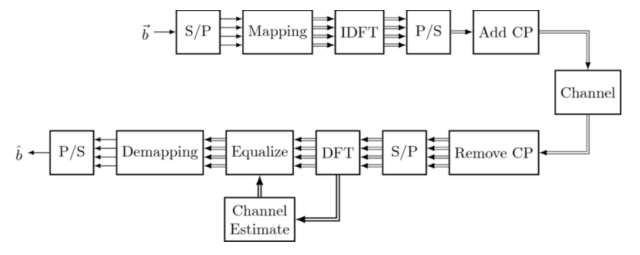

In [20]:
plt.figure(figsize=(8, 10))
img = plt.imread('ofdm_block_diagrma.png')
plt.imshow(img)
plt.axis('off')
plt.show()

All Carriers: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Pilot Carriers: [ 0  8 16 24 32 40 48 56 63]
Data Carriers: [ 1  2  3  4  5  6  7  9 10 11 12 13 14 15 17 18 19 20 21 22]


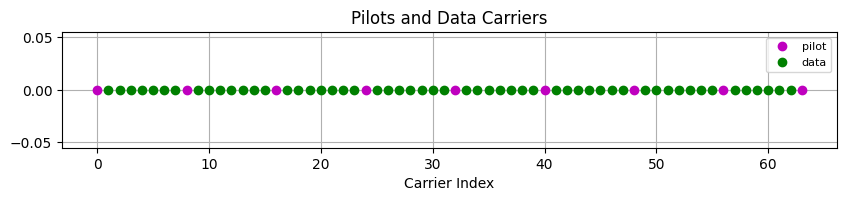

In [21]:
K = 64      # number of OFDM subcarriers
CP = K//4   # length of the cyclic prefix: 25% of the block
P = 8       # number of pilot carriers per OFDM block
pilotValue = 3+3j                   # The known value each pilot transmits
allCarriers = np.arange(K)          # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P] # Pilots is every (K/P)th carrier.

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)

print(f"All Carriers: {allCarriers[0:20]}")
print(f"Pilot Carriers: {pilotCarriers}")
print(f"Data Carriers: {dataCarriers[0:20]}")

plt.figure(figsize=(10, 1.5))
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'mo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'go', label='data')
plt.legend(fontsize=8, loc='upper right')
plt.title('Pilots and Data Carriers')
plt.xlabel('Carrier Index')
plt.grid(True)
plt.show()

Now, I will creat OFDM symbol usng 16-QAM i.e each symbol is represented by n=4 bits. I will now map group of 4 bits into a 16QAM constellation symbol. Which is defined in the mapping table.

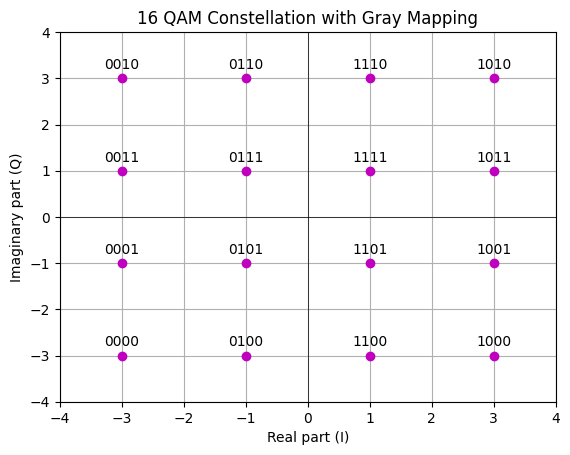

In [22]:
n = 4
payloadBits_per_OFDM = len(dataCarriers)*n     # number of payload bits per OFDM symbol
mapping_table = {
    (0,0,0,0) : -3-3j,
    (0,0,0,1) : -3-1j,
    (0,0,1,0) : -3+3j,
    (0,0,1,1) : -3+1j,
    (0,1,0,0) : -1-3j,
    (0,1,0,1) : -1-1j,
    (0,1,1,0) : -1+3j,
    (0,1,1,1) : -1+1j,
    (1,0,0,0) :  3-3j,
    (1,0,0,1) :  3-1j,
    (1,0,1,0) :  3+3j,
    (1,0,1,1) :  3+1j,
    (1,1,0,0) :  1-3j,
    (1,1,0,1) :  1-1j,
    (1,1,1,0) :  1+3j,
    (1,1,1,1) :  1+1j}

for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'mo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x) for x in B), ha='center')

plt.axis((-4, 4, -4, 4))
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title('16 QAM Constellation with Gray Mapping')
plt.ylabel('Imaginary part (Q)')
plt.xlabel('Real part (I)')
plt.grid(True)
plt.show()


We define a demapping table, which is inverse of mapping table.

In [23]:
demapping_table = {v : k for k, v in mapping_table.items()}

The wireless channel between transmitter and receiver is defined using two-tap multipath channel with given impulse responce.

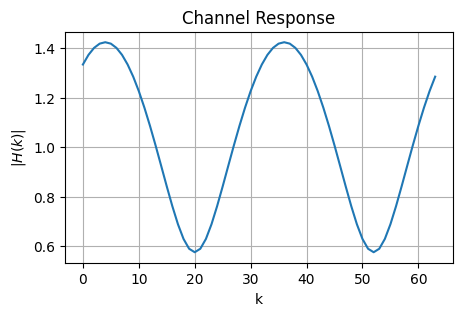

In [24]:
h = np.array([1, 0, 0.3+0.3j])  # the impulse response of the wireless channel
H = np.fft.fft(h, K)

plt.figure(figsize=(5, 3))
plt.ylabel('$|H(k)|$')
plt.xlabel('k')
plt.title('Channel Response')
plt.grid(True)
plt.plot(allCarriers, abs(H))

Now, Let's generate random bits using binomial distribution.

In [25]:
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))
print("Total bits: ", len(bits))
print("First 30 bits: ", bits[0:30])

Total bits:  220
First 30 bits:  [1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1]


These bits are sent to serial to parallel converter, which groups the bits into a group of 4 bits.

Now, the bits groups are sent to the mapper. The mapper converts the groups into complex-valued constellation symbols according to the mapping_table. 

In [26]:
def S_to_P(bits):
    return bits.reshape((len(dataCarriers), n))

def map_bits_to_symbol(bits):
    return np.array([mapping_table[tuple(b)] for b in bits])

bits_S_to_P = S_to_P(bits)
QAM = map_bits_to_symbol(bits_S_to_P)
print("First 5 QAM symbols bits:")
print(bits_S_to_P[:5, :])
print("First 5 QAM symbols:")
print(QAM[:5])

First 5 QAM symbols bits:
[[1 0 0 0]
 [0 0 0 1]
 [0 1 0 1]
 [1 0 0 0]
 [0 1 1 1]]
First 5 QAM symbols:
[ 3.-3.j -3.-1.j -1.-1.j  3.-3.j -1.+1.j]


The OFDM data is created by allocating different subcarriers with data and pilots.

After this, perform IFFT to OFDM data then add cyclic prefix. 

In [27]:
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # the overall K subcarriers
    symbol[pilotCarriers] = pilotValue  # allocate the pilot subcarriers 
    symbol[dataCarriers] = QAM_payload  # allocate the pilot subcarriers
    return symbol

OFDM_data = OFDM_symbol(QAM)
print("Total OFDM carriers in frequency domain: ", len(OFDM_data))
print(OFDM_data[0:10])

Total OFDM carriers in frequency domain:  64
[ 3.+3.j  3.-3.j -3.-1.j -1.-1.j  3.-3.j -1.+1.j  1.+3.j -1.-1.j  3.+3.j
  1.+1.j]


In [28]:
def IFFT(OFDM_data):                   
    return np.fft.ifft(OFDM_data)      # the IFFT

def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               # take the last CP samples
    return np.hstack([cp, OFDM_time])  # add them to the beginning

OFDM_time = IFFT(OFDM_data)
OFDM_withCP = addCP(OFDM_time)

print("Total OFDM data with CP in time domain: ", len(OFDM_withCP))
print("OFDM data in time domain:")
print(OFDM_withCP[0:10])

Total OFDM data with CP in time domain:  80
OFDM data in time domain:
[ 0.375     +0.1875j     -0.0953551 -0.0133418j   0.20390627-0.52933522j
  0.05600066+0.60524863j  0.14168566+0.31814173j -0.12913418-0.07745701j
 -0.29023919-0.2604576j   0.119747  +0.36292707j  0.15088835+0.41161165j
 -0.56489538-0.00999942j]


Now the signal is ready for transmission over the air through wireless channel. 

Signal at receiver is the convolution of transmitted signal and channel impulse responce. We add some noise to received signal with given SNR value.

RX Signal power: 0.20080006450712629 and Noise power: 0.0006349855581512549


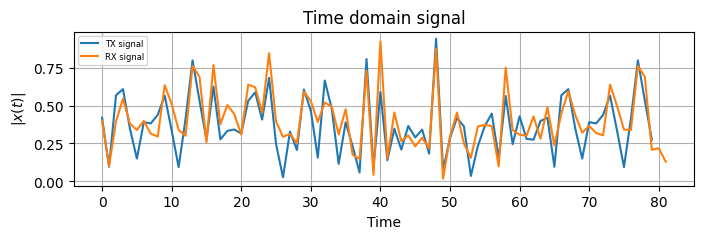

In [29]:
SNRdb = 25  # signal to noise-ratio in dB at the receiver
def channel(signal):
    convolved = np.convolve(signal, h)
    signal_power = np.mean(abs(convolved**2))
    sigma2 = signal_power * 10**(-SNRdb/10)  # calculate noise power based on signal power and SNR
    print(f"RX Signal power: {signal_power} and Noise power: {sigma2}")
    noise = np.sqrt(sigma2/2) * (np.random.randn(*convolved.shape)+1j*np.random.randn(*convolved.shape))    
    return convolved + noise

OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX)
plt.figure(figsize=(8, 2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.title('Time domain signal')
plt.legend(fontsize=6)
plt.xlabel('Time')
plt.ylabel('$|x(t)|$')
plt.grid(True)
plt.show()
    

### Receiver processing

The first step at receiver is to remove the cyclic prefix then take FFT to transform the signal back to frequency domain.

In [30]:
def removeCP(signal):
    return signal[CP:(CP+K)]

def FFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)

OFDM_RX_noCP = removeCP(OFDM_RX)
OFDM_demod = FFT(OFDM_RX_noCP)

In the next step, the wireless channel needs to be estimated. The ZF channel estimation is applied followed by interpolation.

The channel is estimated as follows:

Transmitted signal contains pilot symbol at certain pilot carriers. These pilot valuse and pilot carrier index are known to receiver. From the received information at the pilot subcarriers, the receiver can estimate the effect of the wireless channel onto this subcarrier (because it knows what was transmitted and what was received).

However, receiver wants to know what happened at the data carriers. To achieve this, it interpolates the channel values between the pilot carriers to get an estimate of the channel in the data carriers.

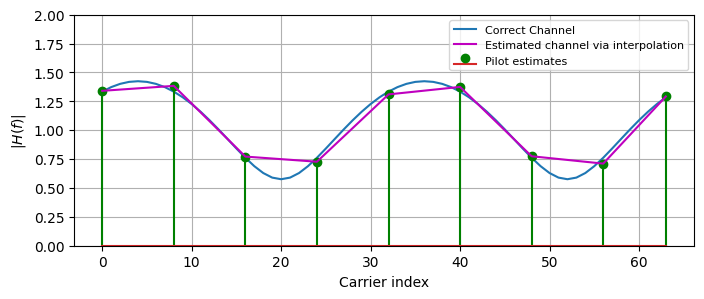

In [31]:
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]   # extract the pilot values from the RX signal
    H_est_at_pilots = pilots / pilotValue # divide by the transmitted pilot values

    ''' 
    Perform interpolation between the pilot carriers to get an estimate of the channel in the data carriers.
    Here, we interpolate absolute value and phase separately because we have to interpolate complex numbers.
    '''
    H_est_abs = scipy.interpolate.interp1d(pilotCarriers, abs(H_est_at_pilots), kind='linear')(allCarriers)
    H_est_phase = scipy.interpolate.interp1d(pilotCarriers, np.angle(H_est_at_pilots), kind='linear')(allCarriers)
    H_est = H_est_abs * np.exp(1j*H_est_phase)
    
    plt.figure(figsize=(8, 3))
    plt.plot(allCarriers, abs(H),  label='Correct Channel')
    plt.stem(pilotCarriers, abs(H_est_at_pilots), 'g', label='Pilot estimates')
    plt.plot(allCarriers, abs(H_est), 'm', label='Estimated channel via interpolation')
    plt.ylabel('$|H(f)|$')
    plt.xlabel('Carrier index')
    plt.legend(fontsize=8)
    plt.ylim(0,2)
    plt.grid(True)
    plt.show()

    return H_est
H_est = channelEstimate(OFDM_demod)

After channel estimation, use this information in channel equalization. Here, for each subcarrier, the influence of the channel is removed such that we get the clear (only noisy) constellation symbols back.

Then, remove the pilot carriers form the equalized symbols to get the data carriers.

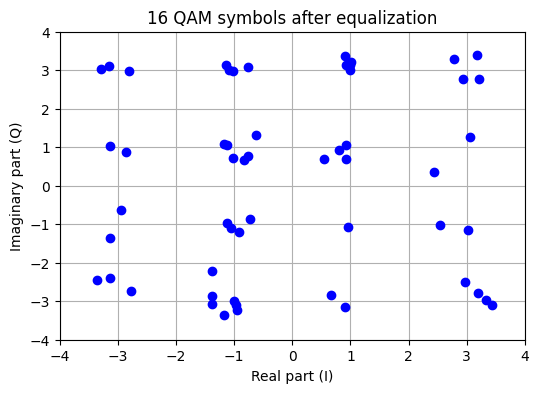

In [32]:
def channel_equalize(OFDM_demod, H_est):
    return OFDM_demod / H_est

def get_payload(equalized):
    return equalized[dataCarriers]

OFDM_demod_equalized = channel_equalize(OFDM_demod, H_est)
QAM_est = get_payload(OFDM_demod_equalized)

plt.figure(figsize=(6, 4))
plt.axis((-4, 4, -4, 4))
#plt.plot(QAM.real, QAM.imag, 'bo', label='before RX')
plt.plot(QAM_est.real, QAM_est.imag, 'bo', label='after RX')
plt.title('16 QAM symbols after equalization')
plt.ylabel('Imaginary part (Q)')
plt.xlabel('Real part (I)')
plt.grid(True)
plt.show()

Now compare each received constellation point against each possible constellation point and choose the constellation point which is closest to the received point. Then, return the bit-group that belongs to this point using demmapping table.

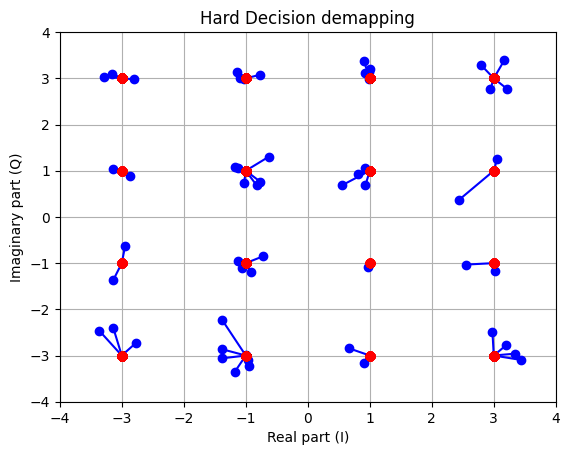

In [33]:
def demapping(QAM):
    # array of possible constellation points
    constellation = np.array([x for x in demapping_table.keys()])
    
    # calculate the distance of each RX point to each possible point
    dists = abs(QAM.reshape((-1, 1)) - constellation.reshape((1, -1)))
    
    # for each element in QAM, choose the index in constellation that belongs to the nearest constellation point
    const_index = dists.argmin(axis=1)
    
    # get back the real constellation point
    hardDecision = constellation[const_index]
    
    # transform the constellation point into bit groups
    return np.vstack([demapping_table[C] for C in hardDecision]), hardDecision

bits_est, hardDecision = demapping(QAM_est)
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o');
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')


plt.axis((-4, 4, -4, 4))
plt.title('Hard Decision demapping')
plt.ylabel('Imaginary part (Q)')
plt.xlabel('Real part (I)')
plt.grid(True)
plt.show()

In the diagram above, the blue points are the received QAM points, where as the the red points connected to them are the closest possible constellation points, and the bit groups corresponding to these red points are returned.

Finally, the bit groups need to be converted to a serial stream of bits, by means of parallel to serial conversion.

In [34]:
def PS(bits):
    return bits.reshape((-1, ))

bits_est = PS(bits_est)

Now, that all bits are decoded, let's calculate the bit error rate:

In [35]:
print(f"Obtained bit error rate: {np.sum(abs(bits-bits_est))/len(bits)}")

Obtained bit error rate: 0.0


Fortunately, no bit error occured and the transmission was successful.
Reduce the SNR to get bit error. 